In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats

Для начала рассмотрим, как устроены данные

In [2]:
payments = pd.read_csv('payments.csv')
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143284 entries, 0 to 143283
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   order_id  143284 non-null  int64  
 1   paid_at   143284 non-null  object 
 2   paid_sum  143284 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.3+ MB


In [3]:
payments.paid_at = pd.to_datetime(payments.paid_at)

In [4]:
orders = pd.read_csv('orders.csv')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at   46472 non-null  object 
 4   issued_sum  55748 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 2.1+ MB


In [5]:
for col in ['created_at', 'put_at', 'closed_at']:
    orders[col] = pd.to_datetime(orders[col])

In [6]:
plan = pd.read_csv('plan.csv')
plan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420282 entries, 0 to 420281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        420282 non-null  int64  
 1   plan_at         420282 non-null  object 
 2   plan_sum_total  420282 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ MB


In [7]:
plan['plan_at'] = pd.to_datetime(plan['plan_at'])

Сразу проверим на наличие пустых значений

In [8]:
orders.isna().sum()

order_id         0
created_at       0
put_at           0
closed_at     9276
issued_sum       0
dtype: int64

Наличие пустых значений в столбце closed_at - нормальная ситуация, так как часть кредитов еще не были закрыты на 8.12.2022

In [9]:
plan.isna().sum()

order_id          0
plan_at           0
plan_sum_total    0
dtype: int64

In [10]:
payments.isna().sum()

order_id    0
paid_at     0
paid_sum    0
dtype: int64

Теперь перейдем непосредственно к анализу данных. Для начала нужно подготовить таблицы к объединению. Поскольку дата реального платежа и дата планового платежа различаются, необходимо использовать "асинхронное" объединение (pd.merge_asof). То есть необходимо объединить дату планового платежа с датой последнего фактического платежа (для которого предварительно рассчитать кумулятивную сумму уже осуществленных платежей). 

In [11]:
#Сначала необходимо отсортировать исходные таблицы по датам
plan.sort_values('plan_at', inplace=True, ignore_index=True)
payments.sort_values('paid_at', inplace=True, ignore_index=True)

#Точное время платежа не играет роли, главное чтобы платеж был совершен не позднее плановой даты.
#Поскольку алгоритм объединения с параметром backward (то есть последнее ближайшее) ищет все даты, которые <= плановой,
#то необходимо избавиться от точного времени платежа, чтобы операции совершенные в тот же день, но после 00:00 тоже учитывались.
payments['paid_at'] = pd.to_datetime(payments['paid_at']).dt.normalize()

#Рассчитаем кумулятивную сумму платежей для каждого выдданного кредита
payments['paid_sum_cum'] = payments.groupby(["order_id"])["paid_sum"].cumsum()

#Объединяем таблицы plan и payments 
merged_plan_payments = pd.merge_asof(plan, payments, left_on='plan_at', right_on='paid_at', by='order_id', direction='backward')

#Все платежи, по которым срок оплаты еще не наступил, нас не интересуют. Поэтому уберем все платежи с плановой датой после 8.12.2022
cutoff_date = pd.to_datetime('2022-12-08')
merged_plan_payments = merged_plan_payments[merged_plan_payments['plan_at'] <= cutoff_date]

#После объединения могли появиться пустые значения, проверим это
merged_plan_payments.isna().sum()

order_id              0
plan_at               0
plan_sum_total        0
paid_at           32013
paid_sum          32013
paid_sum_cum      32013
dtype: int64

In [12]:
#Единственные пустые значения, которые могли возникнуть на данном этапе - это, если клиент ни разу не платил по кредиту к плановой дате
#Поэтому можем интерпритировать их, как 0
merged_plan_payments['paid_sum'] = merged_plan_payments.paid_sum.fillna(0)
merged_plan_payments['paid_sum_cum'] = merged_plan_payments.paid_sum_cum.fillna(0)

#Рассчитаем баланс к плановой дате и определим, просрочен ли платеж или нет
merged_plan_payments['balance'] = merged_plan_payments['paid_sum_cum'] - merged_plan_payments['plan_sum_total']
merged_plan_payments['is_overdue'] = merged_plan_payments['plan_sum_total'] > merged_plan_payments['paid_sum_cum'] 

#Объединим с остальной информацией по кредитам
orders_info_merged = pd.merge(merged_plan_payments, orders, on = 'order_id')
orders_info_merged.head()

,order_id,plan_at,plan_sum_total,paid_at,paid_sum,paid_sum_cum,balance,is_overdue,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02,5600.0,2022-06-02,5600.0,5600.0,0.0,False,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400597887,2022-06-02,2140.0,2022-06-02,2140.0,2140.0,0.0,False,2022-06-02 16:25:19.997,2022-06-02 16:31:20.510,2022-06-16 07:53:39.043,8140.0
2,400600676,2022-06-02,1450.0,2022-06-02,1450.0,1450.0,0.0,False,2022-06-02 16:27:00.000,2022-06-02 20:22:18.473,NaT,3450.0
3,400614946,2022-06-02,720.0,2022-06-02,720.0,720.0,0.0,False,2022-06-02 16:38:54.997,2022-06-02 16:45:27.750,2022-07-17 18:38:55.690,1720.0
4,400077292,2022-06-02,6900.0,2022-06-02,6900.0,6900.0,0.0,False,2022-06-02 06:27:16.997,2022-06-02 06:32:42.960,2022-08-08 00:55:34.410,16900.0


Часть кредитов была закрыта досрочно, что привело к меньшей итоговой сумме платежей, чем планировалось, поскольку проценты не успели накопиться в полном объеме. Поэтому в расчетах показатель того, просрочен платеж или нет, может отражать ложную информацию, так как мы сравниваем плановую сумму и фактическую. Не имея данных по процентной ставке каждого кредита, учесть это невозможно. **Однако, для платежей, где дата закрытия кредита предшествует дате планового платежа, если сумма последнего платежа составляет не менее 80% от плановой, мы будем считать, что такой платеж не является просроченным.**

In [13]:
condition_1 = orders_info_merged['plan_at'] > orders_info_merged['closed_at']
condition_2 = orders_info_merged['paid_sum_cum'] >= 0.8 * orders_info_merged['plan_sum_total']

orders_info_merged.loc[condition_1 & condition_2, 'is_overdue'] = False
orders_info_merged.head()

,order_id,plan_at,plan_sum_total,paid_at,paid_sum,paid_sum_cum,balance,is_overdue,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02,5600.0,2022-06-02,5600.0,5600.0,0.0,False,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400597887,2022-06-02,2140.0,2022-06-02,2140.0,2140.0,0.0,False,2022-06-02 16:25:19.997,2022-06-02 16:31:20.510,2022-06-16 07:53:39.043,8140.0
2,400600676,2022-06-02,1450.0,2022-06-02,1450.0,1450.0,0.0,False,2022-06-02 16:27:00.000,2022-06-02 20:22:18.473,NaT,3450.0
3,400614946,2022-06-02,720.0,2022-06-02,720.0,720.0,0.0,False,2022-06-02 16:38:54.997,2022-06-02 16:45:27.750,2022-07-17 18:38:55.690,1720.0
4,400077292,2022-06-02,6900.0,2022-06-02,6900.0,6900.0,0.0,False,2022-06-02 06:27:16.997,2022-06-02 06:32:42.960,2022-08-08 00:55:34.410,16900.0


Для того, чтобы оценить динамику просроченных платежей, посчитаем их количество по месяцам, а также общее количество платежей 

In [14]:
overdue_by_month = orders_info_merged.groupby(orders_info_merged["plan_at"].dt.to_period("M")).agg(
    overdue_count=("is_overdue", "sum"),
    total_count=("is_overdue", "size")
).reset_index()

overdue_by_month["overdue_ratio"] = overdue_by_month["overdue_count"] / overdue_by_month["total_count"]

Построим график, чтобы оценить динамику. *Под платежом будем понимать не фактический платеж, а плановую дату платежа*. Если платеж не был осуществлён в установленный срок, то он будет считаться просроченным.

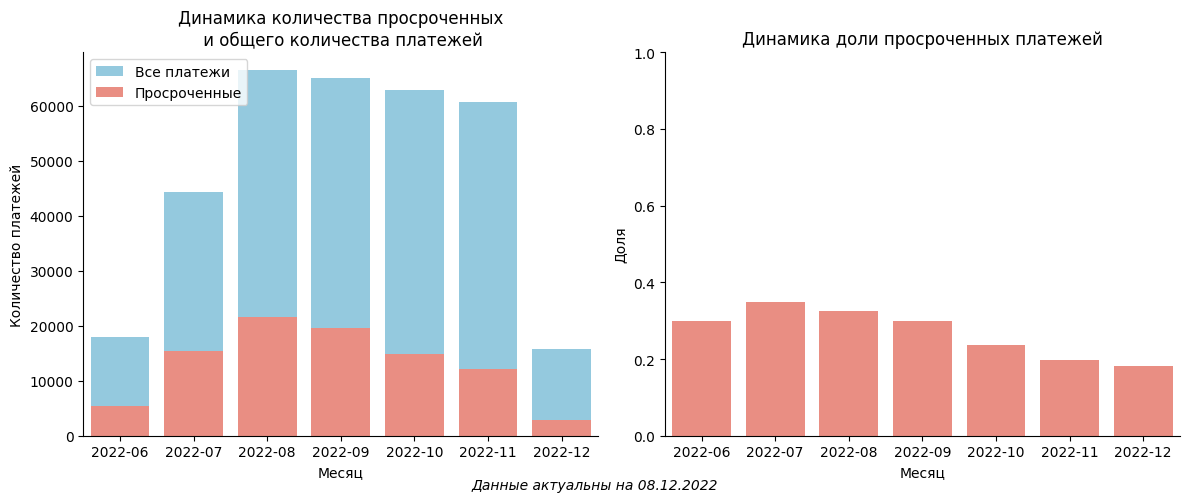

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#График с абсолютными значениями
sns.barplot(x=overdue_by_month["plan_at"].astype(str), y=overdue_by_month["total_count"], ax=axes[0], color = 'skyblue', label='Все платежи')
sns.barplot(x=overdue_by_month["plan_at"].astype(str), y=overdue_by_month["overdue_count"], ax=axes[0], color = 'salmon', label='Просроченные')
axes[0].set_title("Динамика количества просроченных\n и общего количества платежей") 
axes[0].set_xlabel("Месяц")
axes[0].set_ylabel("Количество платежей")
axes[0].legend()

#График с относительными значениями
sns.barplot(x=overdue_by_month["plan_at"].astype(str), y=overdue_by_month["overdue_ratio"], ax=axes[1], color = 'salmon')
axes[1].set_title("Динамика доли просроченных платежей")
axes[1].set_xlabel("Месяц")
axes[1].set_ylabel("Доля")
axes[1].set_ylim(0,1)

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.figtext(0.5, 0.01, f"Данные актуальны на {cutoff_date.strftime('%d.%m.%Y')}", ha="center", fontsize=10, style='italic')

plt.tight_layout()
plt.show()

#### В летние месяцы количество просроченных платежей увеличивалось как в абсолютном, так и в относительном выражении. Пик доли просроченных платежей пришелся на июль (больше трети всех платежей были просрочены), после чего показатель начал снижаться и к ноябрю-декабрю сократился почти в два раза. Общее число кредитов также активно росло летом, а осенью показало небольшой спад.

#### Вероятно, высокая доля просрочек в июле-сентябре, а также рост количества кредитов начиная с августа связаны с тем, что в июле и августе у большинства россиян увеличиваются расходы, поскольку это основные месяцы отпусков. Для тех, кто уже взял займ, это осложняет возможность его выплатить, а у тех, кто вернулся из отпуска, мог снизиться уровень сбережений, что делает их более склонными к новым займам.

Дополнительно рассмотрим, связан ли размер выданного кредита с вероятностью его просрочки. Для этого сгруппируем данные по выданным кредитам и проверим в них наличие хотя бы одного просроченного платежа. Построим график типа "ящик с усами". 

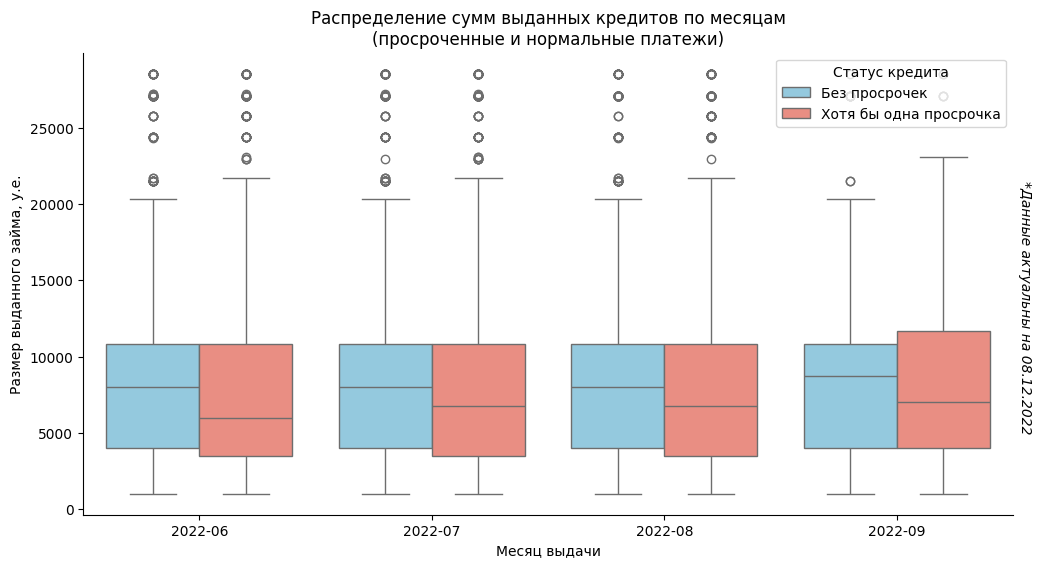

In [16]:
#Группируем данные по кредитам
order_summary = (
    orders_info_merged.groupby("order_id")
    .agg(
        issued_sum=("issued_sum", "first"),  
        issue_month=("put_at", "first"), 
        has_failed_payment=("is_overdue", "max"))
)

order_summary["issue_month"] = order_summary["issue_month"].dt.to_period("M")

plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=order_summary, 
    x="issue_month", 
    y="issued_sum", 
    hue="has_failed_payment",
    palette = ['skyblue', 'salmon']
)

plt.xlabel("Месяц выдачи")
plt.ylabel("Размер выданного займа, у.е.")
plt.title("Распределение сумм выданных кредитов по месяцам\n(просроченные и нормальные платежи)")

plt.legend(title="Статус кредита",  loc = 'upper right')
ax.legend_.texts[0].set_text('Без просрочек')
ax.legend_.texts[1].set_text('Хотя бы одна просрочка')


ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.figtext(0.91, 0.25, f"*Данные актуальны на {cutoff_date.strftime('%d.%m.%Y')}", ha="center", fontsize=10, style='italic', rotation = -90)
plt.show()


На графике более высокая вероятность просрочки наблюдаяется для кредитов меньшего размера. На это **стоит обратить внимание при выдаче кредитов**. Однако, чтобы удостовериться, что мы не ошибаемся, проверим существуют ли статистически значимые различия в размере кредитов между группами с просрочками и без. Нулевой гипотезой будем считать, что наличие просрочки не зависит от размера кредита. Рассчитаем p_value. 

In [17]:
group_overdue = order_summary[order_summary['has_failed_payment'] == 1]
group_no_overdue = order_summary[order_summary['has_failed_payment'] == 0]

t_stat, p_value = stats.ttest_ind(group_overdue['issued_sum'], group_no_overdue['issued_sum'])
print(f"t-stat: {round(t_stat, 3)}, p-value: {round(p_value, 3)}")

t-stat: -13.775, p-value: 0.0


p-value меньше 0.05, а t-статистика меньше -2 --> отвергаем нулевую гипотезу. Значит, действительно, существуют статистически значимые различия в размере кредитов между группами с просрочкой и без. 

Проверим, какая доля кредитов имеет хотя бы один просроченный платеж.

In [18]:
round(orders_info_merged.groupby('order_id')['is_overdue'].max().sum() / len(orders_info_merged.groupby('order_id')),3)

0.51

Примерно половина кредитов имеет хотя бы один просроченный платеж

In [19]:
round(orders_info_merged.dropna(subset=['closed_at']).groupby('order_id')['is_overdue'].last().sum() /
      len(orders_info_merged.dropna(subset=['closed_at']).groupby('order_id')),
      3)

0.066

Тем не менее среди "закрытых" кредитов примерно 6,6% остались не выплаченными, то есть стали невозвратными. 

Также рассмотрим, как связан срок, на который выдан займ, и вероятность просрочки по нему. 

In [20]:
#Рассчитаем срок, на который выдан займ
orders_info_merged['loan_duration'] = (orders_info_merged['closed_at'] - orders_info_merged['created_at']).dt.days

<AxesSubplot: >

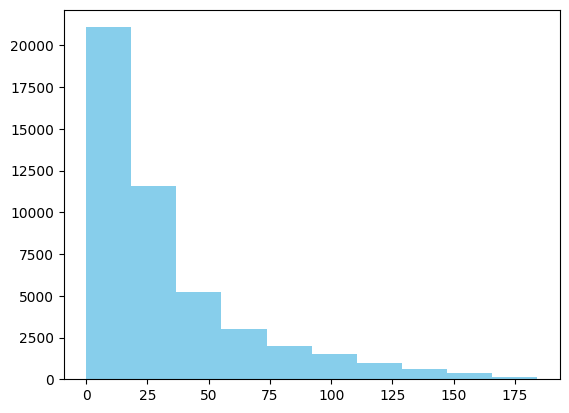

In [21]:
#Посмотрим распределение сроков займов, чтобы понять, как разбивать на категории 
orders_info_merged.groupby('order_id').first().loan_duration.hist(color = 'skyblue', grid = False)

In [22]:
#Гистограмма сильно смещена влево, поэтому чтобы разделить на категории, будем использовать квантили
orders_info_merged['loan_duration_category'] = pd.qcut(orders_info_merged.groupby('order_id')['loan_duration'].transform('first'), 10)
order_duration_summary = (
    orders_info_merged.groupby("order_id").agg(
        loan_duration_category=("loan_duration_category", "first"),  
        is_overdue=("is_overdue", "max"),
))

#observerd=False не учитывает пустые значения
order_duration_summary = order_duration_summary.groupby('loan_duration_category', observed=False)['is_overdue'].mean()
order_duration_summary

loan_duration_category
(-0.001, 11.0]    0.094426
(11.0, 16.0]      0.231746
(16.0, 21.0]      0.535165
(21.0, 26.0]      0.559024
(26.0, 32.0]      0.540420
(32.0, 40.0]      0.632491
(40.0, 53.0]      0.682698
(53.0, 70.0]      0.733642
(70.0, 99.0]      0.762810
(99.0, 184.0]     0.746469
Name: is_overdue, dtype: float64

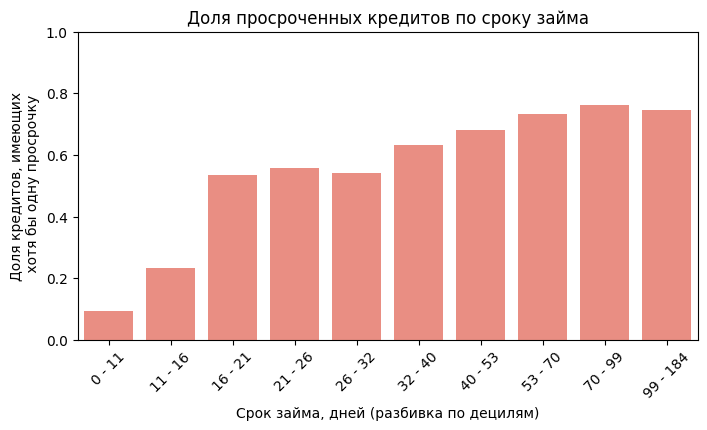

In [23]:
plt.figure(figsize=(8, 4))
sns.barplot(x=order_duration_summary.index, y=order_duration_summary.values, color = 'salmon')

plt.xlabel('Срок займа, дней (разбивка по децилям)')
plt.ylabel('Доля кредитов, имеющих\n хотя бы одну просрочку')
plt.title('Доля просроченных кредитов по сроку займа')
plt.ylim(0,1)

plt.xticks(ticks=range(10), labels=[f'{int(interval.left)} - {int(interval.right)}' for interval in order_duration_summary.index], rotation=45)
plt.show()

По графику можно судить, что чем больше срок, на который выдается займ, тем выше вероятность того, что хотя бы один платеж по нему будет просрочен. Однако проверим это статистически. Разобьем на две группы (просроченные и непросроченные) и посчитаем p-value и t-stat. Нулевой гипотезой будем считать, что не существует разницы между сроками для просроченных и непросроченных кредитов

In [24]:
filtered_df = orders_info_merged.dropna(subset=['loan_duration'])
loan_duration_overdue = filtered_df[filtered_df['is_overdue']]['loan_duration']
loan_duration_not_overdue = filtered_df[~filtered_df['is_overdue']]['loan_duration']

t_stat, p_value = stats.ttest_ind(loan_duration_overdue, loan_duration_not_overdue, equal_var=False)
print(f't-stat={round(t_stat, 3)}, p-value={round(p_value, 3)}')

t-stat=117.564, p-value=0.0


t-статистика больше 2, p-value меньше 0.05 --> отвергаем нулевую гипотезу.

Чтобы оценить, насколько сильная эта зависимость, рассчитаем корреляцию. Поскольку одна из переменных бинарная, а другая непрерывная, то будет использовать точечно-бисериальную корреляцию. 

In [25]:
corr, p_value = stats.pointbiserialr(filtered_df['loan_duration'], filtered_df['is_overdue'])
print(f'Корреляция: {corr}, p-value: {p_value}')

Корреляция: 0.2537659046497306, p-value: 0.0


p-value около нуля, а корреляция 0.25. Это означает, что существет слабая прямая связь между сроком кредита и вероятностью просрочки. 

#### Таким образом, при прочих равных условиях наиболее рискованными оказываются кредиты на небольшие суммы с длительным сроком, выданные в конце лета – начале осени, что требует установления высокой процентной ставки. В то же время, наибольшую вероятность возврата демонстрируют займы на крупные суммы с коротким сроком, оформленные в начале лета или в конце осени (с учетом ограниченного набора данных).